Team:
* Shreyanshu Vyas
* Jan Mueller
* Jyot Makadiya

## Task 1: Constructing the matrix X

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn import model_selection
from scipy.sparse import coo_matrix, csc_matrix, linalg
from os import path

In [3]:
!unzip /content/HD-EML-hs-tomography-zip

Archive:  /content/HD-EML-hs-tomography-zip
   creating: hs_tomography/
  inflating: hs_tomography/alphas_195.npy  
  inflating: hs_tomography/alphas_77.npy  
  inflating: hs_tomography/info.txt  
  inflating: hs_tomography/X_77.npy  
  inflating: hs_tomography/X_example.npy  
  inflating: hs_tomography/y_195.npy  
  inflating: hs_tomography/y_77.npy  


In [4]:
data_path = ""
M = 195
alphas, y = np.load(path.join(data_path, f"hs_tomography/alphas_{M}.npy")), np.load(path.join(data_path, f"./hs_tomography/y_{M}.npy"))

#pixel_res = 77;alphas = np.load("./hs_tomography/alphas_77.npy");ys = np.load("./hs_tomography/y_77.npy")
Np = int(y.shape[0]/alphas.shape[0])

(45, 100)
(45, 100)


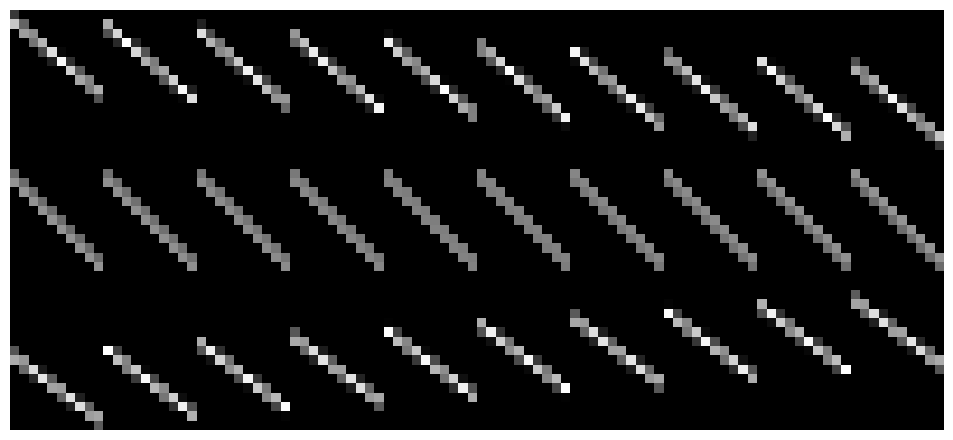

In [5]:
# notes:
# y = flattened sinogram s
# alphas = angles of observation
# X contains no information about the image
# M = sensor resolution


def construct_X(M, alphas, Np = None):
    # Make sure Np is set to enough pixel and is odd

    D = M ** 2
    if Np is None:
        Np = np.ceil(np.sqrt(2)*M)
        if Np % 2 == 0:
            Np += 1
    Np = int(Np)
    N = Np * len(alphas)
    rads = np.radians(alphas)
    sins = np.sin(rads)
    coss = np.cos(rads)

    M_mid = (M-1)/2
    grid = np.mgrid[-M_mid:M-M_mid,-M_mid:M-M_mid].swapaxes(1,2)
    grid = grid.reshape((2,D))
    #grid[1] = -grid[1]


    grid_alpha_x = grid[0]*coss[:,None] - grid[1]*sins[:,None] + (Np-1)/2
    left = np.floor(grid_alpha_x).flatten()
    right = np.ceil(grid_alpha_x).flatten()

    left_val = right - (grid_alpha_x).flatten()
    right_val = grid_alpha_x.flatten() - left
    weights = np.concatenate((left_val,right_val))
    stuff_i = np.repeat(range(len(alphas)),D)
    stuff_i = np.concatenate((stuff_i,stuff_i))
    #print(weights)

    i_indices = np.concatenate((left,right)) + (Np * stuff_i)

    j_indices = np.array([range(D) for i in range(2*len(alphas))]).flatten()

    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = np.float32)

    return X

X_example = np.load(path.join(data_path, f"hs_tomography/X_example.npy"))
print(X_example.shape)
X = construct_X(10,[-33,1,42]).todense()
print(X.shape)
fig = plt.figure(figsize = (10, 4.5))
plt.imshow(X, interpolation = 'nearest')
plt.gray()
plt.axis('off')
fig.tight_layout()
plt.show()

## Task 2

13458956 elements of the matrix are non-zero values
(array([  313,   313,   313, ..., 49188, 49188, 49188], dtype=int32), array([  0,   1,   2, ..., 192, 193, 194], dtype=int32)) elements of the test matrix are non-zero values


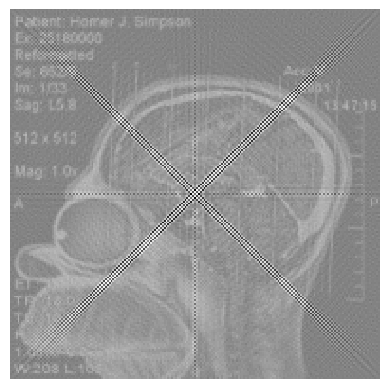

In [20]:
X = construct_X(M, alphas, Np)

# get amount of non-zero entries of X
not_zero = X.count_nonzero()

print('{} elements of the matrix are non-zero values'.format(not_zero))

# convert sparse martrix to dense ndarray for visualization

# testing lsqr
X_test = X.todense()

y_test = np.load(path.join(data_path, 'hs_tomography/y_77.npy'))

X_test = csc_matrix(X_test)

test_not_zero = X_test.nonzero()

print('{} elements of the test matrix are non-zero values'.format(test_not_zero))


beta_test = linalg.lsqr(X, y, atol=1e-05, btol=1e-05)[0]


# reshape to for drawing an image
beta_test = beta_test.reshape(195,195)
# draw test image
plt.gray()
plt.imshow(beta_test, interpolation='nearest')
plt.axis('off')
plt.show()




## Task 3

In [ ]:
#reduce the number of alphas to still be able to reconstruct the image

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsqr, csc_matrix

alphas = np.load('../hs_tomography/alphas_195.npy')
y = np.load('../hs_tomography/y_195.npy')
M = 195
Np = 275

# Try different numbers of projections
for num_projections in [179, 90, 45, 22, 11, 5]:
    # Select a subset of the angles and corresponding measurements
    alphas_subset = np.linspace(alphas.min(), alphas.max(), num_projections)
    y_subset = y[:Np * num_projections]

    # Construct the matrix X
    X = construct_X(M, alphas_subset, Np)

    # Use scipy's lsqr function to solve the system of equations
    result = lsqr(X, y_subset, atol=1e-05, btol=1e-05)
    beta = result[0]  # the solution is the first element of the result

    # Reshape the solution into a 2D image
    image = beta.reshape((M, M))

    # Plot the image
    plt.figure()
    plt.title(f'Number of projections: {num_projections}')
    plt.imshow(image, cmap='gray')
    plt.show()